In [1]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
from pickle import dump
from pickle import load
import joblib
import re
import sweetviz as sv
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance 
rawDataFile='./data/TRCT_TrainingData_20210308.csv'
final_date = '2021-02-01'
# target_ToolGID = 'PK_DUVKrF'
#target_ToolGID = 'XE_Sorter'
target_ToolGID = 'MA_Alps'
NN_ModelFile='./NN/training_model20210308.h5'
XG_ModelFile='XG_model20210308'
LR_ModelFile='LR_model20210308'

In [2]:
def iqrfilter(df, colname, bounds = [.25, .75]):
    s = df[colname]
    Q1 = df[colname].quantile(bounds[0])
    Q3 = df[colname].quantile(bounds[1])
    IQR = Q3 - Q1
    # print(IQR,Q1,Q3,Q1 - 1.5*IQR,Q3+ 1.5 * IQR)
    if bounds[0]==0:
        return df[~s.clip(*[Q1,Q3+ 1.5 * IQR]).isin([Q1,Q3+ 1.5 * IQR])]
    else:
        return df[~s.clip(*[Q1 - 1.5*IQR,Q3+ 1.5 * IQR]).isin([Q1 - 1.5*IQR,Q3+ 1.5 * IQR])]

In [3]:

# def build_model(hp):
    
#     # from tensorflow.keras import layers
#     from kerastuner.tuners import RandomSearch
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Dense(units=hp.Int('units',
#                                         min_value=32,
#                                         max_value=512,
#                                         step=32),
#                            activation='relu'))
#     model.add(tf.keras.layers.Dense(10, activation='softmax'))
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(
#             hp.Choice('learning_rate',
#                       values=[1e-2, 1e-3, 1e-4])),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy'])
#     return model

## NN 模型

In [4]:
def tuningNN(load_model,x,y):
    #tf.keras.wrappers.scikit_learn.KerasClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score, precision_score, recall_score,r2_score
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
    # randcv = RandomizedSearchCV(estimator=MyNN(lr=0.005,nfirst=10,nhidden1=10,nhidden2=0,dropout=0.2,output_bias=0.1,batch_size=100,epochs=1),\
    #                             param_distributions=dict( epochs=[ 50,100,200], batch_size=[ 10,100],nhidden1=[2,5,10],nfirst=[10,20],dropout=[0.2],output_bias=[0.1,0.9],scale_pos_weight=[1,10]),\
    #                             n_iter=30, scoring='f1', n_jobs=1, cv=cv, verbose=1).fit(dftrain[xs], dftrain['y'])

    # pd.DataFrame(randcv.cv_results_).sort_values(by='mean_test_score',ascending=False)
    build_model = lambda: load_model
    Kmodel = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, verbose=1)
    scorers = {
        # 'precision_score': make_scorer(precision_score),
        # 'recall_score': make_scorer(recall_score),
        # 'accuracy_score': make_scorer(accuracy_score)
        'r2_score':make_scorer(r2_score)
        }
        #layers=[[8,16,20],  [45, 30, 15]],


#     distributions = {
# "n_hidden": [0, 1, 2, 3],
# "n_neurons": np.arange(1, 100).tolist(),
# "learning_rate": np.arange(3e-4, 3e-2).tolist()
# }

    distributions = dict(batch_size = [32,64,75], epochs = [30, 50, 75] #  , optimizer=['rmsprop', 'adam']#hidden_layers=[[64], [32]]
    )
    #     batch_size = [10, 20, 40, 60, 80, 100]
#     epochs = [10, 50, 100]
    # activations = ['relu'], 
    # param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
    # grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, cv=5)


    clf = RandomizedSearchCV(Kmodel, distributions, scoring=scorers,random_state=0,n_iter = 5, cv = 2, verbose=10,refit='r2_score')

    from joblib import Parallel, delayed, parallel_backend
    with parallel_backend('threading',n_jobs=12):
        search = clf.fit(x, y)
    
    # print("RandomizedSearchCV took %.2f seconds for %d candidates"
    #       " parameter settings." % ((time() - start), n_iter_search))
    print(clf.best_estimator_.model) 



    # 評估，打分數
    print(f"最佳準確率: {clf.best_score_}，最佳參數組合：{clf.best_params_}")
    # 取得 cross validation 的平均準確率及標準差
    # means = clf.cv_results_['mean_test_score']
    # stds = clf.cv_results_['std_test_score']
    # params = clf.cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #     print(f"平均準確率: {mean}, 標準差: {stdev}, 參數組合: {param}")
    print(clf.cv_results_)

    # {'mean_fit_time': array([ 9.92220247, 11.41317749,  8.51325178,  5.53384042,  6.71829283]), 
    # 'std_fit_time': array([0.15850294, 0.2024827 , 0.09449553, 0.07199621, 0.11651003]), 
    # 'mean_score_time': array([0.39148962, 0.26898944, 1.17896593, 0.75547612, 0.40098655]), 
    # 'std_score_time': array([0.09949863, 0.17497933, 0.10899651, 0.0884949 , 0.03799713]), 
    # 'param_epochs': masked_array(data=[100, 100, 50, 30, 30],
    #          mask=[False, False, False, False, False],
    #    fill_value='?',
    #         dtype=object), 'param_batch_size': masked_array(data=[64, 32, 32, 64, 32],
    #          mask=[False, False, False, False, False],
    #    fill_value='?',
    #         dtype=object), 'params': [{'epochs': 100, 'batch_size': 64}, {'epochs': 100, 'batch_size': 32}, {'epochs': 50, 'batch_size': 32}, {'epochs': 30, 'batch_size': 64}, {'epochs': 30, 'batch_size': 32}], 'split0_test_r2_score': array([-1.42770799, -1.4276857 , -1.4277966 , -1.42778419, -1.42786533]), 'split1_test_r2_score': array([-1.87841303, -1.87841303, -1.87872848, -1.87892689, -1.87892689]), 'mean_test_r2_score': array([-1.65306051, -1.65304937, -1.65326254, -1.65335554, -1.65339611]), 'std_test_r2_score': array([0.22535252, 0.22536367, 0.22546594, 0.22557135, 0.22553078]), 'rank_test_r2_score': array([2, 1, 3, 4, 5])}
 

    return clf.best_estimator_.model

In [5]:
# def tunningNN(create_model,X,Y):
    
#     model = KerasClassifier(build_fn=create_model, verbose=0)
#     # define the grid search parameters
#     batch_size = [10, 20, 40, 60, 80, 100]
#     epochs = [10, 50, 100]
#     param_grid = dict(batch_size=batch_size, nb_epoch=epochs)
#     grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
#     grid_result = grid.fit(X, Y)
#     # summarize results
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     for params, mean_score, scores in grid_result.grid_scores_:
#         print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

In [6]:
def trainNN(df):
    import tensorflow as tf
    save_model_tool = NN_ModelFile
    # save_model_tool = getSavePath(df['TOOLG_ID'].iloc[0],save_model)
    df_result = df.copy(deep=False)
    X_dropped, Y_dropped = preHandleDat(df_result,True)
    # tuneNN(X_dropped,Y_dropped)
    
    # 拆分train validation set NN fit 可以自己拆
    # X_train, X_test,y_train,y_test = train_test_split(X_dropped,Y_dropped,test_size =0.1,random_state=587)
    
    #1.建立模型(Model)
    #將Layer放入Model中
    # Activation Functions
    # A.softmax：值介於 [0,1] 之間，且機率總和等於 1，適合多分類使用。
    # B.sigmoid：值介於 [0,1] 之間，且分布兩極化，大部分不是 0，就是 1，適合二分法。
    # C.Relu (Rectified Linear Units)：忽略負值，介於 [0,∞] 之間。
    # D.tanh：與sigmoid類似，但值介於[-1,1]之間，即傳導有負值。
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]), # units：输出维度
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dense(units=64),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=1)

        
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        # tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),

        #tf.keras.layers.Dense(units=1)
        tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform',activation='relu')
        

        ])
    #model.summary()
    #======================================================================================
    # 定義 tensorboard callback
    tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs2')]
    #======================================================================================
    #2. 確立目標及求解方法：以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。

        #compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
        #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
        
        # # model.compile( loss = root_mean_squared_error,optimizer = "rmsprop",metrics =["accuracy"],callbacks=tensorboard_callback) 
        # model.compile(loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
        # 
    #--------------------------
    #[Keras 損失函數(loss)]
        #   A.均方誤差(mean_squared_error)----mean_squared_error-------------------------------
        #   B.Hinge Error (hinge)：是一種單邊誤差，不考慮負值，適用於『支援向量機』(SVM)的最大間隔分類法(maximum-margin classification)
        #  C.Cross Entropy (categorical_crossentropy)：當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值，這篇文章 主張要用 Cross Entropy 取代 MSE，因為，在梯度下時，Cross Entropy 計算速度較快，其他變形包括 sparse_categorical_crossentropy、binary_crossentropy。
        #  D.其他還有 logcosh、kullback_leibler_divergence、poisson、cosine_proximity 等。
    #--------------------------
    #[優化函數(Optimizer)]
    #   A. 隨機梯度下降法(Stochastic Gradient Descent, SGD)：就是利用偏微分，逐步按著下降的方向，尋找最佳解。它含以下參數：
    #        Learning Rate (lr)：逼近最佳解的學習速率，速率訂的太小，計算最佳解的時間花費較長，訂的太大，可能會在最佳解兩                               旁擺盪，找不到最佳解。
    #        momentum：更新的動能，一開始學習速率可以大一點，接近最佳解時，學習速率步幅就要小一點，一般訂為0.5，不要那麼大時，可改為 0.9。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    #        nesterov：是否使用 Nesterov momentum，請參考 http://blog.csdn.net/luo123n/article/details/48239963 。
    #  B.Adam：一般而言，比SGD模型訓練成本較低，請參考『Adam - A Method for Stochastic Optimization』，包含相關參數建議值，含以下參數：

    #        lr：逼近最佳解的學習速率，預設值為0.001。
    #        beta_1：一階矩估計的指數衰減因子，預設值為0.9。
    #        beta_2：二階矩估計的指數衰減因子，預設值為0.999。
    #        epsilon：為一大於但接近 0 的數，放在分母，避免產生除以 0 的錯誤，預設值為1e-08。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01)
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD()
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    #========================================================================
    # SGD
    sgd = tf.keras.optimizers.SGD(lr=0.20, momentum=0.0, decay=0.0, nesterov=False)
    # 随机梯度下降优化器。
    # 包含扩展功能的支持： - 动量（momentum）优化, - 学习率衰减（每次参数更新后） - Nestrov 动量 (NAG) 优化
    # 参数
    # lr: float >= 0. 学习率。
    # momentum: float >= 0. 参数，用于加速 SGD 在相关方向上前进，并抑制震荡。
    # decay: float >= 0. 每次参数更新后学习率衰减值。
    # nesterov: boolean. 是否使用 Nesterov 动量。
    #========================================================================
    # compile 編譯模型
    # model.compile(loss='mean_squared_error', optimizer='adam'
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 」‘「＝、
    
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(lr=0.01,decay=1e-6, momentum=0.9, nesterov=True)
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 
    # model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])
    
    # model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])   
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01) #, optimizer=tf.keras.optimizers.SGD(lr=0.2)
                        , metrics = [ 'mae', 'mape'])   
    # model = tuningNN(model,X_dropped,Y_dropped)                                            
    #======================================================================================

    #3.訓練 fit：以compile函數進行訓練，指定訓練的樣本資料(x, y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式。
    # train_history = model.fit(x=X_dropped, y=Y_dropped,
    #                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
    #                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
    train_history = model.fit(x=X_dropped, y=Y_dropped,
                #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
                validation_split=0.20, epochs=100, batch_size=64, verbose=0) #,shuffle=True validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
    # train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    
    model.save(save_model_tool)
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

    #評估(Evaluation)：訓練完後，計算成效。
    # 顯示訓練成果(分數)
    # scores = model.evaluate(X_dropped, Y_dropped) 
    
    # print("Finished training the model",scores)
    print(train_history.history.keys())
    #dict_keys(['loss', 'accuracy', 'mse', 'mae', 'mape', 'val_loss', 'val_accuracy', 'val_mse', 'val_mae', 'val_mape'])
    
    # 當RMSE收斂至接近0.02，且MAPE接近10%，即完成模型之訓練
    figure, axis_1 = plt.subplots()
    plt.title(df['TOOLG_ID'].iloc[0]) # title
    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")

    loss = axis_1.plot(train_history.history['loss'], label = 'loss')

    #plt.ylabel("accuracy")
    # ac =axis_1.plot(train_history.history['accuracy'], label = 'accuracy' )# 準確度
    # ac =axis_1.plot(train_history.history['mse'], label = 'mse' )# 準確度
    
    
    
    # mse = axis_1.plot(train_history.history['mse'], label = 'mse' ) 
    # vallossaxis_1= axis_1.plot(train_history.history['val_loss'], label = 'val_loss' )# 準確度
    axis_2 = axis_1.twinx()
    # mse = axis_2.plot(train_history.history['mse'], label = 'mse',color='red' ) 
    mse = axis_2.plot(train_history.history['mape'], label = 'mape',color='red' ) 
    
    # mape = axis_2.plot(train_history.history['mape'], label = 'mape' )# 準確度 接近10%
        
    axis_1.legend(loc='upper left',fontsize='large')
    axis_2.legend(loc='upper right',fontsize='large')
    # plt.legend((ac, valloss, mse, mape),
    #        ('Low accuracy', 'val_loss', 'mse', 'mape'),
    #        scatterpoints=1,
    #        loc='upper right',
    #     #    ncol=3,
    #        fontsize=14)

    plt.show()

    from sklearn.metrics import mean_squared_error #均方誤差
    from sklearn.metrics import mean_absolute_error #平方絕對誤差
    from sklearn.metrics import r2_score#R square
    #呼叫
    y_predict = model.predict(X_dropped)
    #print(np.count_nonzero(~np.isnan(Y_dropped)),np.count_nonzero(~np.isnan(y_predict)))
    Y_dropped = np.nan_to_num(np.nan, copy=True)
    # Y_dropped = np.nan_to_num(np.nan, copy=True)
    
    # print("mean_squared_error",mean_squared_error(Y_dropped,y_predict))
    # print("mean_absolute_error",mean_absolute_error(Y_dropped,y_predict))
    # print("r2_score",r2_score(Y_dropped,y_predict))
    #return df_test_eh

In [7]:
def testNN(df,df_real):
    import tensorflow as tf
    save_model_tool = NN_ModelFile #'./NN/training_model2.h5'
    model = tf.keras.models.load_model(save_model_tool)
    df_result=df.copy(deep=False)
    
    X_dropped,Y_dropped = preHandleDat(df)
    y_predict = model.predict(X_dropped)
    df_result['predict'] = y_predict # 預測
    

    df_result_real=df_real.copy(deep=False)
    X_dropped_real,Y_dropped_real = preHandleDat(df_result_real)
    y_predict_real = model.predict(X_dropped_real)
    df_result_real['predict'] = y_predict_real # 預測


    # df.plot.scatter(x ='NO_HOLD_QTY', y='predict')#,style='o',figsize=(10,5), grid=True  )
    # ax.locator_params(integer=True)
    
   
 
    plt.figure(figsize=(6, 5))# 设置图片尺寸
    plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (NN)")
    # t = np.arange(len(X_dropped))# 创建t变量
    plt.plot(df_result['MFG_DATE'], Y_dropped, 'r', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    plt.plot(df_result['MFG_DATE'], y_predict, 'g', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') # 绘制predict曲线
    plt.legend()
    plt.yticks(np.linspace(0.0,0.8,9))
    plt.savefig('./Result/NNtest2.png')
    return df_result

## XG 模型

In [8]:
def trainXG(df):
    import xgboost as xgb
    
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.2,random_state=587)
    cv_params = {'n_estimators': [500,600, 630, 660],'max_depth':[11,13,15],'min_child_weight':[1,3,5]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)

    optimized_GBM.fit(X_train, y_train) 

    test_score = optimized_GBM.score(X_test,y_test)

    print('test 得分:{0}'.format(test_score))
    # evalute_result = optimized_GBM.grid_scores_
    # print('每輪迭代執行結果:{0}'.format(evalute_result))
    
    print('引數的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
    print('cv_results_',optimized_GBM.cv_results_)

    bst_model = optimized_GBM.estimator
    print(bst_model)

    
    bst_model.fit(X_train, y_train)
    plot_importance(bst_model)#,max_num_features=10)
    plt.show()

    joblib.dump(bst_model, XG_ModelFile)

In [9]:
def testXG(df,df_real):
    X_test,y_test = preHandleDat(df,False)
    # print(X_test)
    #print(X_test,y_test)
    df_result=df.copy(deep=False)
    loaded_model = joblib.load(XG_ModelFile)#('XG_model')
    y_predict = loaded_model.predict(X_test)
    df_result['predict'] = y_predict
    
    loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    
    df_result_real=df_real.copy(deep=False)
    X_dropped_real,Y_dropped_real = preHandleDat(df_result_real)
    y_predict_real = loaded_model.predict(X_dropped_real)
    df_result_real['predict'] = y_predict_real # 預測





    # y_test real 与 y_predict的可视化
    plt.figure(figsize=(6, 5))# 设置图片尺寸
    plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (XG)")
    # t = np.arange(len(X_test))# 创建t变量
    # plt.plot(df_result['MFG_DATE'], y_test, 'r', linewidth=1, marker='.', label='real') # 绘制y_test曲线
    # plt.plot(df_result['MFG_DATE'], y_predict, 'g', linewidth=1, marker='.', label='predict') # 绘制predict曲线
    # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='real predict') # 绘制predict曲线
    plt.plot(df_result['MFG_DATE'], y_test, 'r', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    plt.plot(df_result['MFG_DATE'], y_predict, 'g', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') 
    plt.legend()
    plt.yticks(np.linspace(0.0,0.8,9))
    plt.savefig('./Result/XGtest2.png')
    return df_result

### normalize 釋義:是否對數據進行標準化處理
設置:bool型,可選,默認False,建議將標準化的工作放在訓練模型之前,通過設置sklearn.preprocessing.StandardScaler來實現，而在此處設置為false 當fit_intercept設置為false的時候，這個參數會被自動忽略。如果為True,回歸器會標準化輸入參數：減去平均值，並且除以相應的二範數


### copy_X 釋義:是否對X複製
設置:bool型、可選、默認True,如為false，則即經過中心化，標準化後，把新數據覆蓋到原數據上

### n_jobs釋義:計算時設置的任務個數,
這一參數的對於目標個數>1（n_targets>1）且足夠大規模的問題有加速作用
設置:int or None, optional, 默認None,如果選擇-1則代表使用所有的CPU。


## LR 模型

In [10]:
def trainLR(df):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.01,random_state=587)
    model = LinearRegression(fit_intercept=True, normalize=True, copy_X=False) #fit_intercept=False
   
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    #print(y_predict)
    print("r2:", model.score(X_test, y_test))# 拟合优度R2的输出方法
    print("MAE:", metrics.mean_absolute_error(y_test, y_predict))# 用Scikit_learn计算MAE
    print("MSE:", metrics.mean_squared_error(y_test, y_predict)) # 用Scikit_learn计算MSE
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))# 用Scikit_learn计算RMSE
    print("intercept_ :",model.intercept_)
    # print("coef_", model.coef_)
    joblib.dump(model, LR_ModelFile)
    # print(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))#計算準確率分數)

    # print((y_predict-y_test)/y_test)

    return y_predict

In [11]:
def testLR(df,df_real):
    from sklearn.linear_model import LinearRegression
    
    X_test,y_test = preHandleDat(df,False)
    # print(df)
    # print(X_test,y_test)
    loaded_model = joblib.load(LR_ModelFile)
    y_predict = loaded_model.predict(X_test)
    df_result=df.copy(deep=False)
    df_result['predict'] = y_predict
    
    loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    
    df_result_real=df_real.copy(deep=False)
    X_dropped_real,Y_dropped_real = preHandleDat(df_result_real)
    # print(X_dropped_real,Y_dropped_real)
    y_predict_real = loaded_model.predict(X_dropped_real)
    df_result_real['predict'] = y_predict_real # 預測

    # y_test real 与 y_predict的可视化
    plt.figure(figsize=(6, 5))# 设置图片尺寸
    # t = np.arange(len(X_test))# 创建t变量
    plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0] + " (LR)")
    # plt.plot(df_result['MFG_DATE'], y_test, 'r', linewidth=1, marker='.', label='real') # 绘制y_test曲线
    # plt.plot(df_result['MFG_DATE'], y_predict, 'g', linewidth=1, marker='.', label='predict') # 绘制predict曲线
    # plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='real predict') # 绘制predict曲线
    plt.plot(df_result['MFG_DATE'], y_test, 'r', linewidth=1, marker='.', label='actual') # 绘制y_test曲线
    plt.plot(df_result['MFG_DATE'], y_predict, 'g', linewidth=1, marker='.', label='predict on 28 days') # 绘制predict曲线
    plt.plot(df_result_real['MFG_DATE'], y_predict_real, 'k', linewidth=1, marker='.', label='predict on actual') 
    plt.legend()
    plt.yticks(np.linspace(0.0,0.8,9))
    plt.savefig('./Result/test2.png')
    return df_result


# 資料 預處理 preHandleDat()

In [12]:
def preHandleDat(df,isTrain=True):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化

    #=================
    #刪除不必要的欄位
    #=================
    print(df.columns)
    drop_cols=['MFG_DATE','ARRIVAL_WIP_QTY','MOVE_QTY']
    num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','NO_HOLD_QTY','WIP_QTY','IS_HOLIDAY',
    'PROCESS_JOBTIME','REWORK_LOT_RATE',
    'RUN_WIP_RATIO'] 
    target_cols=['TRCT']
    cat_cols = ['TOOLG_ID']
    df = df.drop(drop_cols, axis=1)
    #df_train['Finish']=np.where(df_train['TOOLG_ID_NEXT'].isnull(), 1, 0).astype(str)
    #df_train['WEEKDAY']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()
    # df['MFG_DATE']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d')
    #'IS_HOLIDAY'
     
    # df = df.drop('WIP_QTY', axis=1)
    # df = df.sort_values('NO_HOLD_QTY')
    # print("DATA Start====")
    # print(df.info())  
    #========================
    # 缺漏值填空
    #========================
    df = df.fillna(df.median())
    #df = df.fillna(method='bfill') #往後
    #df = df.fillna(method='ffill') #往前
    # df = df.fillna(df.mean())  #用平均值取代 nan   
    # df = df.dropna() # 刪除null值   
    df['REWORK_LOT_RATE'].fillna(value=0, inplace=True) #用 0 取代 nan
    #df['ColA'].fillna(value=df.groupby('ColB')['ColA'].transform('mean'), inplace=True) #利用 groupby()同一group 的平均值

    #==================================================
    #1.特徵縮放
    #==================================================
    
    #特徵縮放欄位 List(排除Target TRCT)==================
    # num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE']

   #'ARRIVAL_WIP_QTY',,'WIP_QTY'
    df_train_scal = df.copy(deep=False)
    global df_cols
    df_cols = df_train_scal.columns
    
    if isTrain:
        
        
        #rescaling 特徵縮放 StandardScaler-------------------------------------
        # scaler = StandardScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])
    
        #rescaling 特徵縮放 MinMaxScaler-------------------------------------
        scaler = MinMaxScaler()
        scaler.fit(df[num_cols])
        df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])

        #rescaling 特徵縮放 RobustScaler-------------------------------------
        # scaler = RobustScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols] = scaler.transform(df_train_scal[num_cols])
        
       
        dump(scaler, open('scaler.pkl', 'wb'))
        # # save the scaler
        # dump(scaler, open('scaler.pkl', 'wb'))
    else:
        # load the scaler
        scaler = load(open('scaler.pkl', 'rb'))
        df_train_scal[num_cols] = scaler.transform(df[num_cols])



     #==================================================
    #2.one hot encoder
    #==================================================
    # target_cols=['MOVE_QTY']
 
    global df2_train_eh_before
    df_train_eh =pd.get_dummies(df_train_scal.drop(target_cols, axis=1),columns=cat_cols)
    # save the scaler


    if isTrain:
        df2_train_eh_before = df_train_eh.copy(deep=False)
    else:
        df_train_eh = df_train_eh.reindex(columns = df2_train_eh_before.columns, fill_value=0)

    df_train_scal.to_csv('./df_train_scal.csv')
    #print(df_train_scal.drop(target_cols, axis=1).describe())
    # print("one hot encoder====")
    # print(df_train_eh.info())


    # df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
    #df_test_eh = df_test_eh.reindex(columns = df_test_eh.columns, fill_value=0)
   
    #np.asarray(x).astype('float32')        
           
    X_dropped = np.asarray(df_train_eh)

    Y_dropped = np.asarray(df[target_cols]) 
    return X_dropped,Y_dropped
    

In [13]:
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

In [14]:
def EDA(df_train,targetfeat='MOVE_QTY'):
    
    pairwise_analysis='off' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
    report_train = sv.analyze([df_train, 'train'],
                                    target_feat= targetfeat,
                                    pairwise_analysis = pairwise_analysis
    )
    report_train.show_html(filepath='./sweetvizHTML/train_report.html' ) # 儲存為html的格式

    # compare_subsets_report = sv.compare_intra(df_train,
    #                                         df_train['Finish']==1, # 給條件區分
    #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
    #                                         target_feat='NO_HOLD_QTY',
    #                                         )

    # compare_subsets_report.show_html(filepath='./sweetvizHTML/HW2_Compare_report.html')

In [15]:
df_train_orign=readDataFromFile(rawDataFile)
 
df_train_orign = df_train_orign.loc[df_train_orign['TOOLG_ID']==target_ToolGID]
#df_train_orign['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
df_train_orign['MFG_DATE'] = df_train_orign['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

df_train = df_train_orign
# df_train.info()
# 1. 查看缺失情况
# print(df_train.isnull().sum())
# print(df_train.describe())# 128683

#df2_test = df2_test.dropna()# 刪除null值

# 'MFG_DATE','TOOLG_ID','IS_HOLIDAY','M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE'
# num_cols=['WIP_QTY','NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
# missData(df_train)

#刪除columns 值是空的()
df_train = df_train.dropna(axis=1, how='all')
 
# #刪除rows ,target值是空的()
df_train = df_train[df_train['MOVE_QTY'].notna()]
df_train = df_train[df_train['NO_HOLD_QTY'].notna()]
# df_train['TRCT']= df_train['NO_HOLD_QTY']/df_train['MOVE_QTY']
df_train['TRCT']= df_train['NO_HOLD_QTY']/df_train['MOVE_QTY']

 

df_train.isnull().sum()
#df_train.info()
# 檢查資料處理  value  是不是有 無限大
# x,y=preHandleDat(df_train)
 
# # # np.isnan(y.any()) #and gets False
# # # np.isfinite(y.all()) #and gets True

# print(np.all(np.isfinite(x)))
# print(np.all(np.isfinite(y)))

# #trainLR(df_train)

MFG_DATE             0
TOOLG_ID             0
IS_HOLIDAY           0
M_NUM                0
UP_TIME              0
C_UP_TIME            0
LOT_SIZE             0
C_LOT_SIZE           0
EQP_UTIL             0
C_EQP_UTIL           0
U                    0
PROCESS_TIME       200
PROCESS_JOBTIME      0
WIP_QTY              0
NO_HOLD_QTY          0
MOVE_QTY             0
ARRIVAL_WIP_QTY      0
RUN_WIP_RATIO        0
C_TC                 0
HOLD_RATE            0
ENG_LOT_RATE         0
HOT_LOT_RATE         0
REWORK_LOT_RATE      0
QUE_LOT_RATE         0
TRCT                 0
dtype: int64

## 資料分析 Tool

In [16]:
df_train.columns

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')

In [17]:

#資料分析 Tool
# EDA(df_train,'TRCT')

In [18]:

# df_train1 = df_train[df_train['MFG_DATE'] <  pd.to_datetime('2021-01-20')]
df_train1 = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]

df_train1 =iqrfilter(df_train1,'M_NUM',[0.25, 1]) 
df_train1['MFG_DATE'].max()


Timestamp('2021-01-30 00:00:00')

# 模型 訓練

In [19]:
# EDA(df_train1,'TRCT')

# 推估當天 28天 df_sum28

In [20]:
df_train['PROCESS_TIME']

181       1.125251
464       1.119899
753       1.144987
1042      1.168454
1331      1.286014
            ...   
120506         NaN
120801         NaN
121103         NaN
121405         NaN
121710         NaN
Name: PROCESS_TIME, Length: 375, dtype: float64

##取得當天的生產資訊
#### C_LOT_SIZE
#### LOT_SIZE
#### PROCESS_TIME
#### WIP_QTY
#### NO_HOLD_QTY
#### ARRIVAL_WIP_QTY
#### HOLD_RATE
#### ENG_LOT_RATE
#### HOT_LOT_RATE
#### QUE_LOT_RATE

### process time 是進出站點的時間
### process jobtime是進機台到出站點的時間

In [21]:
def getsum28(df_train,final_date):
    
    test = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]
    # test['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
    print(test['MFG_DATE'].max())
    df = test.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first())
    # df = test.groupby('User').apply(lambda x: x.set_index('Date').resample('1D').first())
    num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE',
    'PROCESS_JOBTIME',
    'REWORK_LOT_RATE',
    'QUE_LOT_RATE','MOVE_QTY']
    # num_cols=['M_NUM']
    # df1[num_cols] = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean())
    # df1 = df.groupby(level=0)['Value']
    #         .apply(lambda x: x.shift().rolling(min_periods=1,window=2).mean())
    #         .reset_index(name='Value_Average_Past_2_days')

    df_sum28 = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean()).reset_index()
    
    #df_train1['MFG_DATE'].max()
    df_sum28['MFG_DATE'].max()
    #抓最後一天的數據 來預測當天的值 df_test_today
    df_test_today=df_sum28.loc[df_sum28['MFG_DATE']==df_sum28['MFG_DATE'].max()]
     
    # # df_test_today['MFG_DATE'] = df_sum28['MFG_DATE'].max()+ datetime.timedelta(days=1)
    # weekno = df_test_today['MFG_DATE'].max().weekday()

    # if weekno < 5:
    #     df_test_today['IS_HOLIDAY'] = 1
    # else:  # 5 Sat, 6 Sun
    #     df_test_today['IS_HOLIDAY'] =1.0527

    real_data_cols_withkeys =['MFG_DATE','TOOLG_ID','C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY','IS_HOLIDAY'
    ,'REWORK_LOT_RATE'
    ]
    real_data_cols =['C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY','IS_HOLIDAY'
    ,'REWORK_LOT_RATE'
    ]
    df_map_today = df_train[real_data_cols_withkeys] 
    df_map_today=df_map_today.loc[df_map_today['MFG_DATE']==df_test_today['MFG_DATE'].max()]

    for index, row in df_test_today.iterrows():
        r = df_map_today[real_data_cols].loc[(df_map_today['MFG_DATE']==row['MFG_DATE'])  & (df_map_today['TOOLG_ID']==row['TOOLG_ID'])]
        if(r.any(axis=None)):
            for col in real_data_cols:
                df_test_today.loc[index,col]  =r[col].values
        else:
            df_test_today.drop(index, inplace=True)
        
    #測試集的答案 驗證用
    df_test_today['TRCT']= df_test_today['NO_HOLD_QTY']/df_test_today['MOVE_QTY']
    # df_test_today['TRCT']= df_test_today['MOVE_QTY']
    return df_test_today

In [22]:
# df_train.to_csv('./data/data_train.csv')
# num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
# df_train.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first()).groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).max()).reset_index().to_csv('./data/data_train28.csv')

# df_train['MFG_DATE'].iloc[0]


In [23]:
#  df_test_today['MFG_DATE'].iloc[0].weekday()

# 訓練資料 抓28天平均 generationTraininDatFrame()

In [24]:
def generationTraininDatFrame(_dfRaw):
    # test = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]
    test = _dfRaw
    # test.to_csv('./data/dfRaw.csv')
    # test['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
    # print(test['MFG_DATE'].max())
    df = test.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first())
    # df = test.groupby('User').apply(lambda x: x.set_index('Date').resample('1D').first())
    num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE',
    'REWORK_LOT_RATE',
    'PROCESS_JOBTIME','QUE_LOT_RATE','MOVE_QTY']
    # num_cols=['M_NUM']
    # df1[num_cols] = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean())
    # df1 = df.groupby(level=0)['Value']
    #         .apply(lambda x: x.shift().rolling(min_periods=1,window=2).mean())
    #         .reset_index(name='Value_Average_Past_2_days')

    df_sum28 = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean()).reset_index()
    #df_train1['MFG_DATE'].max()
    # df_sum28.to_csv('./data/df_sum28.csv')
     
 
    _df_result = pd.DataFrame(columns = df_sum28.columns)
 
    for index, df_sum28_row  in df_sum28.iterrows():
        
        if index<=28:
            continue
        #print(df_sum28_row['MFG_DATE'])
        #df_test_today=df_sum28.loc[df_sum28['MFG_DATE']==df_sum28_row['MFG_DATE']]
        df_test_today=df_sum28_row
        
        
        #計算 MFG_DATE(移除不需要自己加一天 ， 移動平均算的試當天以前28天不含當日)
        # df_test_today['MFG_DATE'] = df_sum28_row['MFG_DATE'] + datetime.timedelta(days=1)
        # print(df_sum28_row['MFG_DATE'])
        # weekno = df_sum28_row['MFG_DATE'].weekday()
        # #計算 IS_HOLIDAY
        
        # if weekno < 5:
        #     df_test_today['IS_HOLIDAY'] = 1
        # else:  # 5 Sat, 6 Sun
        #     df_test_today['IS_HOLIDAY'] =1.0527
         

        real_data_cols_withkeys =['MFG_DATE','TOOLG_ID','C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY','IS_HOLIDAY']
        real_data_cols =['C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY','IS_HOLIDAY']

        #取得當天的WIP 實際資料===========================
        df_map_today = _dfRaw[real_data_cols_withkeys] 
        df_map_today=df_map_today.loc[df_map_today['MFG_DATE']==df_sum28_row['MFG_DATE']]
        df_map_today=df_map_today.loc[df_map_today['TOOLG_ID']==df_sum28_row['TOOLG_ID']] #+ datetime.timedelta(days=1)]
 
       
        # for index, row in df_test_today.iterrows():
        #     print(row)
        #     r = df_map_today[real_data_cols].loc[(df_map_today['MFG_DATE']==row['MFG_DATE'])  & (df_map_today['TOOLG_ID']==row['TOOLG_ID'])]
        # if(df_map_today.any(axis=None)):
        if df_map_today.shape[0]==0:
            continue
        for col in real_data_cols:
            # print(col)
            # print(df_map_today.iloc[0][col])
            df_test_today[col] = df_map_today.iloc[0][col] 
            # df_test_today.loc[index,col]  =df_map_today[col].values
        # else:
        #     df_test_today.drop(index, inplace=True)
            
        #測試集的答案 驗證用
        df_test_today['TRCT']= df_test_today['NO_HOLD_QTY']/df_test_today['MOVE_QTY']
        _df_result = _df_result.append(df_test_today,ignore_index=True)
        # df_test_today['TRCT']= df_test_today['MOVE_QTY']
        # _df_result = iqrfilter(_df_result,'M_NUM',[.25, 1]) 
        
    return _df_result

## 訓練集取28天平均 df_train_sum28 
### df_train_sum28_1 <==區分訓練與驗證


In [25]:

df_train_sum28_org = generationTraininDatFrame(df_train)
print(df_train_sum28_org)
df_train_sum28 = df_train_sum28_org

    TOOLG_ID   MFG_DATE     M_NUM   UP_TIME  C_UP_TIME   LOT_SIZE  C_LOT_SIZE  \
0    MA_Alps 2020-02-20  4.000000  0.796522   0.146418  24.333333    0.170070   
1    MA_Alps 2020-02-21  4.000000  0.791373   0.147278  22.162162    0.186280   
2    MA_Alps 2020-02-22  4.000000  0.775242   0.151344  23.486486    0.176583   
3    MA_Alps 2020-02-23  4.000000  0.771186   0.151982  22.628571    0.182367   
4    MA_Alps 2020-02-24  4.000000  0.770307   0.152339  23.457627    0.176455   
..       ...        ...       ...       ...        ...        ...         ...   
341  MA_Alps 2021-03-04  6.888889  0.829627   0.166960  23.576923    0.179852   
342  MA_Alps 2021-03-05  6.888889  0.824296   0.168135  24.461538    0.173419   
343  MA_Alps 2021-03-06  6.888889  0.818812   0.169094  24.250000    0.174913   
344  MA_Alps 2021-03-07  6.888889  0.813895   0.169853  22.769231    0.186238   
345  MA_Alps 2021-03-08  6.888889  0.814339   0.169761  20.035714    0.211631   

     EQP_UTIL  C_EQP_UTIL  

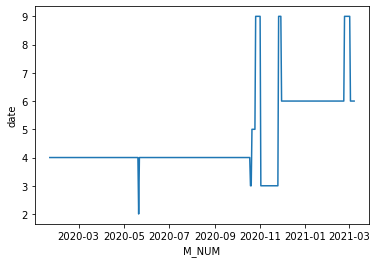

In [26]:
# plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0])
plt.xlabel("M_NUM")
plt.ylabel("date")
plt.plot(df_train['MFG_DATE'] , df_train['M_NUM'])
# plt.savefig('./'+df['TOOLG_ID'].iloc[0]+'.pdf',width=600, height=350)
plt.show()


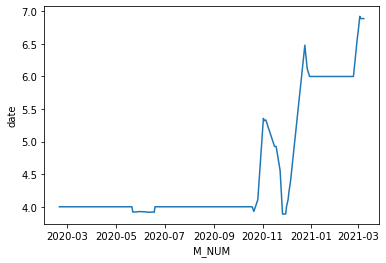

In [27]:


#刪除偏離值
df_train_sum28_1  =iqrfilter(df_train_sum28,'TRCT',[.25, 1]) 
# plt.title('TOOLG_ID:'+ df['TOOLG_ID'].iloc[0])
plt.xlabel("M_NUM")
plt.ylabel("date")
plt.plot(df_train_sum28['MFG_DATE'] , df_train_sum28['M_NUM'])
# plt.savefig('./'+df['TOOLG_ID'].iloc[0]+'.pdf',width=600, height=350)
plt.show()



df_train_sum28_1 = df_train_sum28[df_train_sum28['MFG_DATE'] <  pd.to_datetime(final_date)]

df_train_sum28.to_csv('./data/df_train_sum28.csv')

In [28]:
df_train_sum28_1

,TOOLG_ID,MFG_DATE,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,C_EQP_UTIL,U,...,C_TC,HOLD_RATE,ENG_LOT_RATE,HOT_LOT_RATE,REWORK_LOT_RATE,PROCESS_JOBTIME,QUE_LOT_RATE,MOVE_QTY,IS_HOLIDAY,TRCT
0,MA_Alps,2020-02-20,4.0,0.796522,0.146418,24.333333,0.170070,0.659043,0.610941,0.629920,...,1.466110,0.147727,0.000000,0.029505,0.002819,2.156137,0.359326,949.0,0.9499,0.079031
1,MA_Alps,2020-02-21,4.0,0.791373,0.147278,22.162162,0.186280,0.671628,0.599191,0.623253,...,1.458109,0.102133,0.006098,0.000000,0.002819,2.172141,0.304878,820.0,0.9499,0.060976
2,MA_Alps,2020-02-22,4.0,0.775242,0.151344,23.486486,0.176583,0.675225,0.597592,0.618523,...,1.454476,0.000000,0.000000,0.044879,0.002819,2.168106,0.445339,1738.0,1.0000,0.113349
3,MA_Alps,2020-02-23,4.0,0.771186,0.151982,22.628571,0.182367,0.677944,0.596265,0.610763,...,1.459386,0.013696,0.000000,0.106061,0.002819,2.157912,0.640152,1584.0,1.0000,0.094697
4,MA_Alps,2020-02-24,4.0,0.770307,0.152339,23.457627,0.176455,0.680515,0.595100,0.610802,...,1.463213,0.010174,0.000000,0.088150,0.002819,2.182967,0.603324,1384.0,0.9499,0.162572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,MA_Alps,2021-01-26,6.0,0.859919,0.152131,23.177778,0.182536,0.529175,0.794793,0.335208,...,0.000000,0.000000,0.000000,0.024928,0.005981,2.003942,0.370086,1007.0,0.9499,0.024826
308,MA_Alps,2021-01-27,6.0,0.857689,0.152377,23.975000,0.176509,0.534677,0.781634,0.341378,...,0.000000,0.014723,0.002086,0.027112,0.005709,2.016364,0.251303,926.0,0.9499,0.079914
309,MA_Alps,2021-01-28,6.0,0.866113,0.150852,24.206897,0.174798,0.549875,0.754175,0.340589,...,0.000000,0.000000,0.000000,0.000000,0.005709,2.032632,0.299145,676.0,0.9499,0.036982
310,MA_Alps,2021-01-29,6.0,0.870368,0.150058,23.100000,0.183174,0.537763,0.774043,0.343818,...,0.000000,0.000000,0.000000,0.056277,0.005461,2.016713,0.718615,446.0,0.9499,0.056054


In [29]:
# EDA(df_train_sum28_1,'TRCT')

In [30]:
df_train_sum28_1['MFG_DATE'].max()

Timestamp('2021-01-30 00:00:00')

## 計算測試集資料 取28天平均 df

In [31]:
df = pd.DataFrame(columns = df_train.columns)

for i in range(1,((df_train['MFG_DATE'].max()- datetime.datetime.strptime(final_date, "%Y-%m-%d")).days)+2 ):
    _final_date =   datetime.datetime.strptime(final_date, "%Y-%m-%d")+ datetime.timedelta(days=i)
 
    _df = getsum28(df_train,_final_date)
    df = df.append(_df,ignore_index=True)
    
# print(df.shape)
# print(df.describe())

df.to_csv('./data/MyToday20200120_CT.csv')

2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-02 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
C:\ProgramData\Anaconda3\envs\PY379\lib\site-packages\pandas\core\indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)
C:\ProgramData\Anaconda3\envs\PY379\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
ipykernel_launcher:51: SettingWithCopyWarning: 
A value is trying to be 

## 1. 28 均值 訓練 跑 LR


In [32]:
#實際值
df_test_real =  df_train[df_train['MFG_DATE'] >=  pd.to_datetime(final_date)]


In [33]:
df_test_real.head()

,MFG_DATE,TOOLG_ID,IS_HOLIDAY,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,C_EQP_UTIL,...,MOVE_QTY,ARRIVAL_WIP_QTY,RUN_WIP_RATIO,C_TC,HOLD_RATE,ENG_LOT_RATE,HOT_LOT_RATE,REWORK_LOT_RATE,QUE_LOT_RATE,TRCT
111258,2021-02-01,MA_Alps,0.9499,6.0,0.933550,0.136785,14.888889,0.284406,0.249038,1.319459,...,132.0,132.0,1.0,0.0,0.000000,0.00000,0.149254,0.447761,0.552239,0.189394
111556,2021-02-02,MA_Alps,0.9499,6.0,0.543021,0.235295,17.875000,0.236993,0.116612,2.817995,...,140.0,165.0,0.0,0.0,0.061458,0.00000,0.000000,0.027972,0.629371,0.178571
112153,2021-02-04,MA_Alps,0.9499,6.0,0.822049,0.155490,23.312500,0.181914,0.735515,0.446822,...,373.0,372.0,2.0,0.0,0.000000,0.00000,0.268097,0.000000,0.536193,0.134048
112444,2021-02-05,MA_Alps,0.9499,6.0,0.914133,0.139780,21.916667,0.193543,0.413203,0.795458,...,260.0,311.0,0.0,0.0,0.000000,0.00000,0.095057,0.000000,0.809886,0.188462
112744,2021-02-06,MA_Alps,1.0000,6.0,0.956655,0.133507,18.111111,0.234197,0.389865,0.843060,...,318.0,318.0,4.0,0.0,0.000000,0.01227,0.082822,0.000000,0.920245,0.314465


In [34]:
print(df_test_real.columns)

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')


In [35]:
df_train_sum28_1.head()

,TOOLG_ID,MFG_DATE,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,C_EQP_UTIL,U,...,C_TC,HOLD_RATE,ENG_LOT_RATE,HOT_LOT_RATE,REWORK_LOT_RATE,PROCESS_JOBTIME,QUE_LOT_RATE,MOVE_QTY,IS_HOLIDAY,TRCT
0,MA_Alps,2020-02-20,4.0,0.796522,0.146418,24.333333,0.170070,0.659043,0.610941,0.629920,...,1.466110,0.147727,0.000000,0.029505,0.002819,2.156137,0.359326,949.0,0.9499,0.079031
1,MA_Alps,2020-02-21,4.0,0.791373,0.147278,22.162162,0.186280,0.671628,0.599191,0.623253,...,1.458109,0.102133,0.006098,0.000000,0.002819,2.172141,0.304878,820.0,0.9499,0.060976
2,MA_Alps,2020-02-22,4.0,0.775242,0.151344,23.486486,0.176583,0.675225,0.597592,0.618523,...,1.454476,0.000000,0.000000,0.044879,0.002819,2.168106,0.445339,1738.0,1.0000,0.113349
3,MA_Alps,2020-02-23,4.0,0.771186,0.151982,22.628571,0.182367,0.677944,0.596265,0.610763,...,1.459386,0.013696,0.000000,0.106061,0.002819,2.157912,0.640152,1584.0,1.0000,0.094697
4,MA_Alps,2020-02-24,4.0,0.770307,0.152339,23.457627,0.176455,0.680515,0.595100,0.610802,...,1.463213,0.010174,0.000000,0.088150,0.002819,2.182967,0.603324,1384.0,0.9499,0.162572


In [36]:
df_train_sum28_1.columns

Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')

In [37]:
#  X_dropped_real,Y_dropped_real = preHandleDat(df_test_real)
#  print(Y_dropped_real)

Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')
r2: -0.1670040243465063
MAE: 0.12440285457181105
MSE: 0.021209624939766206
RMSE: 0.1456352462138414
intercept_ : [-1.45883782]
Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')
r2: 0.6053797503806831
Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT

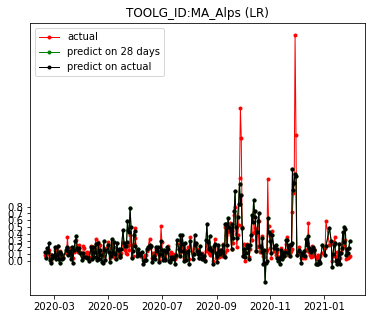

In [38]:
 
trainLR(df_train_sum28_1)
def_result= testLR(df_train_sum28_1,df_train_sum28_1)
print("Train acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
r2: -5.366192848091519
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
Test acc%: -inf


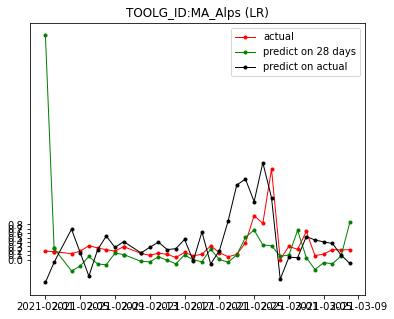

In [39]:

def_result= testLR(df,df_test_real)
print("Test acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])


## 2. 28 均值 訓練 跑 XG

Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   56.0s finished
test 得分:0.5996403810655009
引數的最佳取值：{'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 500}
最佳模型得分:0.25612277237780817
cv_results_ {'mean_fit_time': array([0.57441182, 0.80024419, 0.84487953, 0.83064771, 1.04636755,
       1.06288991, 0.97585869, 0.9792254 , 1.07610145, 1.49416757,
       1.41954722, 1.62890429, 0.72153902, 0.65711918

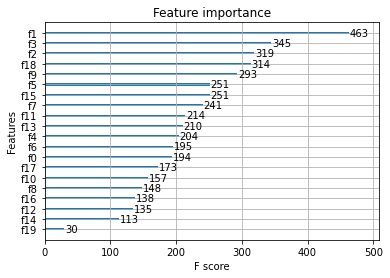

Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')
r2: 0.9198457879058888
Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')
Train acc%: -inf
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBT

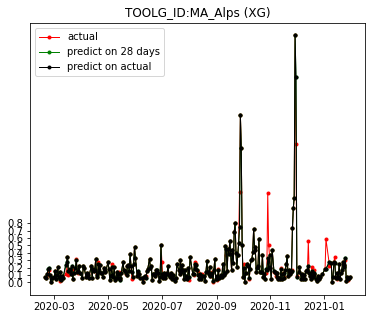

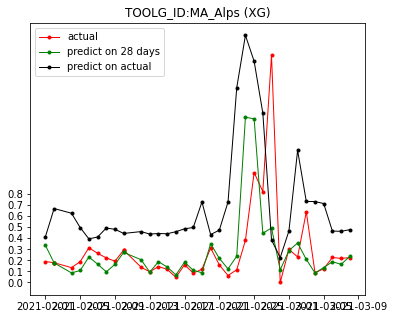

In [40]:

trainXG(df_train_sum28_1)
def_result= testXG(df_train_sum28_1,df_train_sum28_1)

print("Train acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
def_result= testXG(df,df_test_real)
print("Test acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])

## 3. 28 均值 訓練 跑 NN

Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')
dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


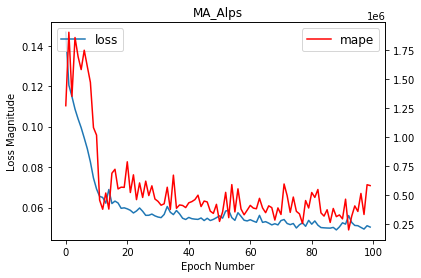

Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')
Index(['TOOLG_ID', 'MFG_DATE', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
       'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME', 'WIP_QTY',
       'NO_HOLD_QTY', 'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE',
       'ENG_LOT_RATE', 'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'PROCESS_JOBTIME',
       'QUE_LOT_RATE', 'MOVE_QTY', 'IS_HOLIDAY', 'TRCT'],
      dtype='object')
Train acc%: -inf
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HO

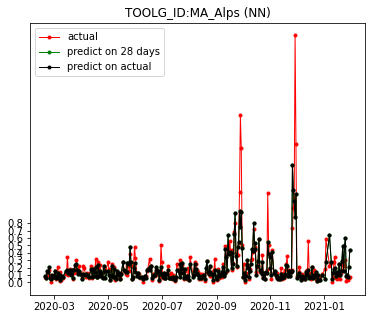

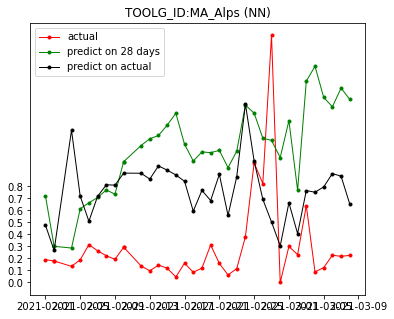

In [41]:
trainNN(df_train_sum28_1)
def_result= testNN(df_train_sum28_1,df_train_sum28_1)
print("Train acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
def_result= testNN(df,df_test_real)
print("Test acc%:",sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])

# 訓練並測試模型( 每日歷史資料 訓練)

##  1. 每日歷史資料 跑 LR


Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
r2: -0.24095463762344949
MAE: 0.044847475426100146
MSE: 0.003831800868687803
RMSE: 0.061901541731105555
intercept_ : [0.04431904]
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
r2: 0.7826915579440314
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 

-inf

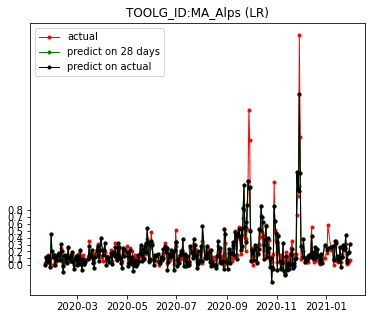

In [42]:
# trainLR(df_train)

trainLR(df_train1)
def_result = testLR(df_train1,df_train1)
# def_result['acc'] = (1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))
# def_result['acc'].sum()/def_result.shape[0]
sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]

In [43]:
def_result.shape[0]

341

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
r2: -0.7078462572548812
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')


-inf

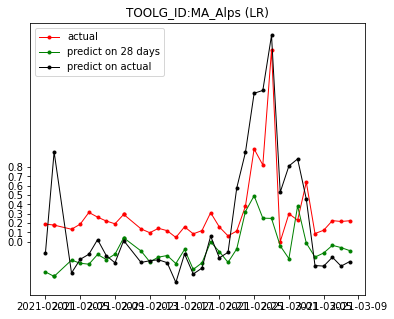

In [44]:
# testLR(df_test_todayOK)
# testLR(df).to_csv('./data/MyToday20200120_result_CT.csv')

def_result = testLR(df,df_test_real)
# testLR( df_train[df_train['MFG_DATE'] ==  pd.to_datetime(final_date)  + datetime.timedelta(days=1)])
#計算準確率分數

sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]

## 2.每日歷史資料 跑 XGBoost


Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   51.0s finished
test 得分:0.8944204879833947
引數的最佳取值：{'max_depth': 11, 'min_child_weight': 3, 'n_estimators': 500}
最佳模型得分:0.6564866819672142
cv_results_ {'mean_fit_time': array([0.68774729, 0.67240109, 0.64035888, 0.57925582, 1.1308794 ,
       0.90847297, 0.85143437, 1.05678859, 1.58896298, 1.34557509,
       1.27920203, 1.18378468, 0.55206957, 0.58871346,

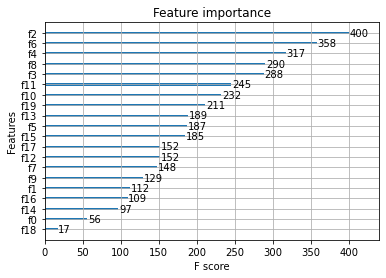

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
r2: 0.990129893669676
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
-inf
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QT

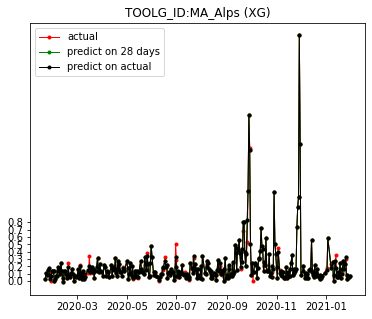

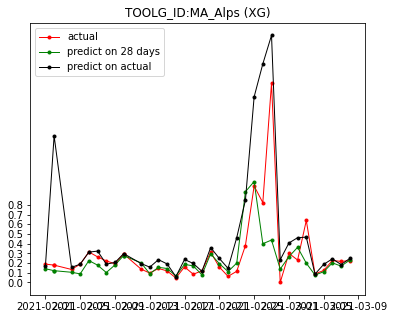

In [45]:
#驗證訓練集 train
trainXG(df_train1)
def_result = testXG(df_train1,df_train1)
print(sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])
#驗證測試集  test
def_result = testXG(df,df_test_real)
print(sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0])

In [46]:
df_train1.columns

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')

## 3.每日歷史資料 跑 NN

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


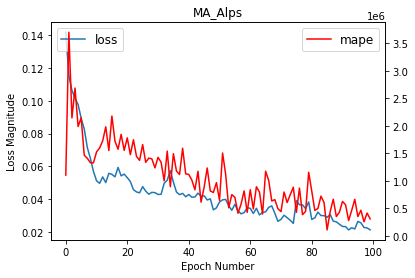

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')


nan

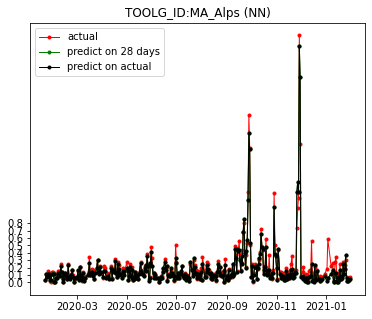

In [47]:
trainNN(df_train1)
def_result = testNN(df_train1,df_train1)
sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]

Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')
Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')


-inf

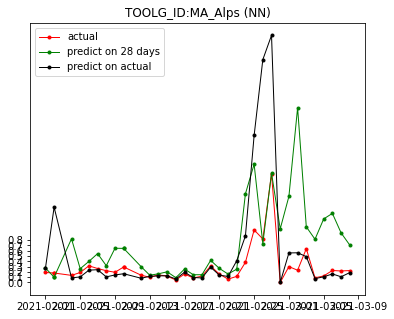

In [48]:
def_result = testNN(df,df_test_real)
sum(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))/def_result.shape[0]

In [49]:
df_test_real.to_csv("./data/df_test_real.csv")
df_train_sum28_1.to_csv('./data/df_train_sum28_1.csv')
df.to_csv('./data/df.csv')

In [50]:
df_train.columns


Index(['MFG_DATE', 'TOOLG_ID', 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME',
       'LOT_SIZE', 'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
       'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
       'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
       'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'TRCT'],
      dtype='object')

In [51]:
def PCA(df):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化
    from sklearn.model_selection import train_test_split
    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.3, random_state=587)
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)
    # standardize the feature 標準化單位方差
    sc = StandardScaler()
    df_pca = df.copy(deep=False)
    x_train_std = sc.fit_transform(df_pca.drop(['MFG_DATE','TOOLG_ID'],axis=1))
    # x_test_std = sc.fit_transform(x_test)
    # print(x_train_std)
 
    # 構造協方差矩陣，得到特徵向量和特徵值
    cov_matrix = np.cov(x_train_std.T)
    eigen_val, eigen_vec = np.linalg.eig(cov_matrix)
    # print("values\n ", eigen_val, "\nvector\n ", eigen_vec)
 
    # 解釋方差比
    tot = sum(eigen_val)  # 總特徵值和
    var_exp = [(i / tot) for i in sorted(eigen_val, reverse=True)]  # 計算解釋方差比，降序
    # print(var_exp)
    # cum_var_exp = np.cumsum(var_exp)  # 累加方差比率
    # plt.rcParams['font.sans-serif'] = ['SimHei']  # 顯示中文
    # plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='獨立解釋方差')  # 柱狀 Individual_explained_variance
    # plt.step(range(1, 14), cum_var_exp, where='mid', label='累加解釋方差')  # Cumulative_explained_variance
    # plt.ylabel("解釋方差率")
    # plt.xl         ZAabel("主成分索引")
    # plt.legend(loc='right')
    # plt.show()

    # 特徵變換
    eigen_pairs = [(np.abs(eigen_val[i]), eigen_vec[:, i]) for i in range(len(eigen_val))]
    eigen_pairs.sort(key=lambda k: k[0], reverse=True)  # (特徵值，特徵向量)降序排列
    # print(eigen_pairs)
    w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))  # 降維投影矩陣W
    # print(w)
    x_train_pca = x_train_std.dot(w)
    # print(x_train_pca)
    color = ['r', 'g', 'b']
    marker = ['s', 'x', 'o']
    # for l, c, m in zip(np.unique(y_train), color, marker):
    #     plt.scatter(x_train_pca[y_train == l, 0],
    #                 x_train_pca[y_train == l, 1],
    #                 c=c, label=l, marker=m)
    # plt.title('Result')
    # plt.xlabel('PC1')
    # plt.ylabel('PC2')
    # plt.legend(loc='lower left')
    # plt.show()

In [52]:
# PCA(df_train1)

In [53]:
np.linspace(0.0,0.7,8)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [54]:
# #EDA(df_train1,'TRCT')
# feature_config = sv.FeatureConfig(skip=['LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY'
# ],  # 要忽略哪個特徵
#                                 #   force_cat=[ 'LOT_ID', 'STATUS', 'CHIPNAME', 'LAYER','PRIORITY', 'LOT_TYPE',  'WS_DATE','IS_MAIN_ROUTE'], # Categorical特徵
#                                 #   force_num=['WIP_QTY','REMAIN_LAYER_SEQ'], # Numerical特徵
#                                   force_text=None
#                                   ) # Text特徵
# pairwise_analysis = 'on'
# my_report = sv.compare([df_train.fillna(0) , "all Data"], [df_test_real.fillna(0) , "Test Data"],  target_feat="TRCT", feat_cfg=feature_config)
# my_report.show_html(filepath='./sweetvizHTML/df_train.html' ) # 儲存為html的格式

Feature: MFG_DATE                            |█         | [ 11%]   00:00 -> (00:06 left)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().